### Introduction to the problem

A key challenge in high-availability systems is determining the appropriate allocation of resources to maintain stability while minimizing costs. Auto-scaling addresses this by dynamically adjusting resource usage in response to current demand. Effective auto-scaling, however, requires accurate forecasting of incoming requests, making this an important problem for statistical modeling.

Consider an employee portal. It is rarely accessed outside working hours and typically experiences a steady, moderate load on most workdays. On the last workday of the month, however, traffic spikes as employees review and correct missing clock-in records. A second spike occurs on the last workday before or on the 5th, when employees receive their pay and check their payslips.

### First steps: modeling a point process of independent events

If we model access patterns as a Poisson process, a nonhomogeneous Poisson distribution is an appropriate choice.

Consider a scenario with 1 request every five minutes (0.2 requests/min) outside office hours. During office hours the rate is approximately 100 requests/min, except on the last day of the month when it rises to 800 requests/min and on the 5th when it reaches 500 requests/min. In this case the rate function $\lambda$ depends on the day of the month:

In [1]:
import pandas as pd
from brandedpipes import __

from datetime import datetime, timedelta
from time import strptime

from dataclasses import dataclass, field

outside_office_hours_rate = 0.2
office_hours_rate = 100
payday_rate = 500
clockin_rate = 800
office_hours_start=8
office_hours_end = 18

@dataclass
class BaseModel:
    outside_office_hours_rate: float = 0.2
    office_hours_rate:  float = 100
    payday_rate:        float = 500
    clockin_rate:       float = 800
    office_hours_start: int   =   8
    office_hours_end:   int   =  18
    event_counts:       dict = field(default_factory=dict)

    def rate_function(self, date):
        """
        Return the rate of access to the web app per minute for every day.
    
        It is very low outside business days...

        >>> model = BaseModel()
        >>> model.rate_function(D('2024-05-11 9:40'))
        0.2
    
        ...and business hours:
    
        >>> model.rate_function(D('2024-12-19 7:00'))
        0.2
    
        Usually it is quite mild during office hours:
    
        >>> model.rate_function(D('2024-12-19 9:40'))
        100
    
        Every payday (day 5 or earliest), though, it spikes to 500 req/minute:
    
        >>> model.rate_function(D('2024-11-05 12:55'))
        500
        >>> model.rate_function(D('2024-10-04 12:59'))
        500
    
        In the last workday of the month, it spikes to 800 reqs/minunte due to
        clock-in adjustments
    
        >>> model.rate_function(D('2024-02-29 10:00'))
        800
        >>> model.rate_function(D('2024-6-28 10:00'))
        800
        """
        if not self.is_office_hours(date):
            return self.outside_office_hours_rate
        if is_last_business_day_wrt(date, 5):
            return self.payday_rate
        if is_last_business_day_wrt(date, last_day_of_month(date)):
            return self.clockin_rate
        return self.office_hours_rate

    def register_event_count(self, date, count):
        """
        Storing the results inside the model will prove useful in some ways we will
        extend this model.
        """
        self.event_counts[date] = count

    def reset(self):
        self.event_counts = {}

    def is_office_hours(self, date):
        if not is_business_day(date):
            return False
        if date.hour < self.office_hours_start:
            return False
        if date.hour > self.office_hours_end-1:
            return False
        return True

def last_day_of_month(date):
    """
    >>> last_day_of_month(D('2012-02-14'))
    29
    """
    first_day_current_month = datetime(date.year, date.month, 1)
    next_month = first_day_current_month + timedelta(days=31)
    first_day_next_month = datetime(next_month.year, next_month.month, 1)
    return previous_day(first_day_next_month).day

def is_last_business_day_wrt(date, day):
    """
    Receives a date and a day of the month. Returns true if
    the date is the day and is also a business day:

    >>> is_last_business_day_wrt(D('2025-09-05'), 5)
    True

    If the date is not in that day of the month, and in that
    month the given day is not a business day, it returns
    True if the given date is the last business day before
    the given day:

    >>> is_last_business_day_wrt(D('2024-10-04'), 5)
    True
    >>> is_last_business_day_wrt(D('2025-09-5'), 7)
    True

    It will return false if the date is not a business day...

    >>> is_last_business_day_wrt(D('2024-10-5'), 5)
    False

    ...or if it is not the given day of the month:

    >>> is_last_business_day_wrt(D('2024-10-3'), 4)
    False
    """
    if not is_business_day(date):
        return False
    if date.day == day:
        return True
    nd = next_day(date)
    while not is_business_day(nd):
        if nd.day == day:
            return True
        nd = next_day(nd)
    return False

def is_business_day(date):
    """
    Returns true if the date is a business date (not considering holidays):

    >>> is_business_day(D('2025-09-05'))
    True
    >>> is_business_day(D('2025-09-06'))
    False
    """
    workdays = pd.bdate_range(start=date, end=date)
    return __| workdays | len | bool |__

def previous_day(date):
    return date + timedelta(days=-1)

def next_day(date):
    return date + timedelta(days=1)

def D(s):
    """
    For testing and debug only.
    """
    try:
        sd = strptime(s, '%Y-%m-%d %H:%M')
    except ValueError as e:
        sd = strptime(s, '%Y-%m-%d')
    return datetime(*sd[:5])

Using this setup, we can simulate behavior over an extended period (e.g., two months) to observe emerging patterns:

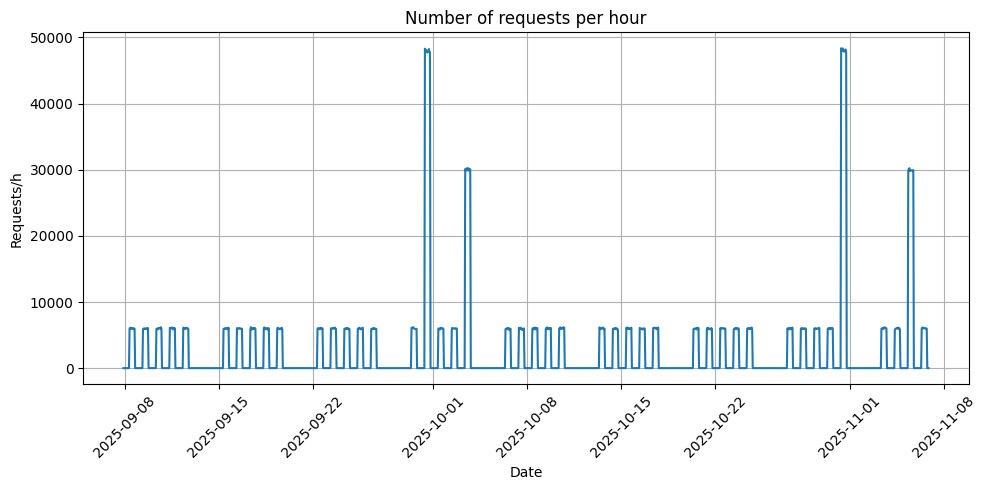

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_requests(model, start_time, horizon, interval_size):
    try:
        for t in range(horizon):
            interval_start = start_time + timedelta(hours=t)
            rate = model.rate_function(interval_start) * interval_size
            event_count = np.random.poisson(rate)
            model.register_event_count(interval_start, event_count)
    
        return model.event_counts
    finally:
        model.reset()

def plot_simulation(events, marker=None):
    sorted_items = sorted(events.items())
    dates = [item[0] for item in sorted_items]
    values = [item[1] for item in sorted_items]
    plt.figure(figsize=(10, 5))
    plt.plot(dates, values, marker=marker, markerfacecolor='red', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Requests/h')
    plt.title('Number of requests per hour')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

HOUR = 60

# Three months, more or less
horizon = 60*24

start_time = datetime.now()

base_model1 = BaseModel()
event_simulation = simulate_requests(base_model1, datetime.now(), horizon, HOUR)
plot_simulation(event_simulation)

Now let us observe a smaller interval, so we can see more clearly how it behaves locally:

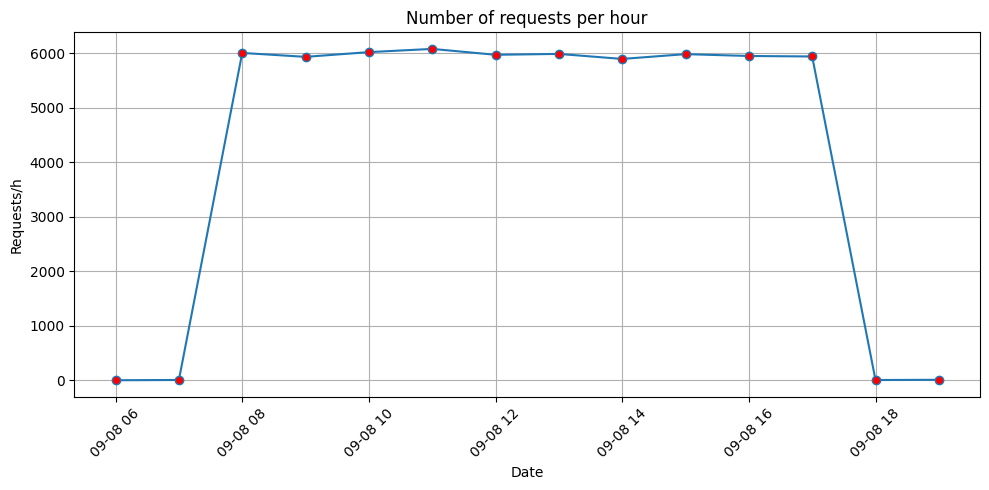

In [3]:
# One day
horizon = 14

start_time = D('2025-09-08 06:00')

base_model2 = BaseModel()

event_simulation = simulate_requests(base_model2, start_time, horizon, HOUR)
plot_simulation(event_simulation, marker='o')


### The rate of the resoures does not raise at once

The jump in request numbers appears quite steep, whereas in reality it is usually smoother. This can be addressed by treating the rate as a random variable that decreases near the edges of office hours. One approach is to multiply the base rate by a time-dependent factor, for example, generated using a Gaussian function:

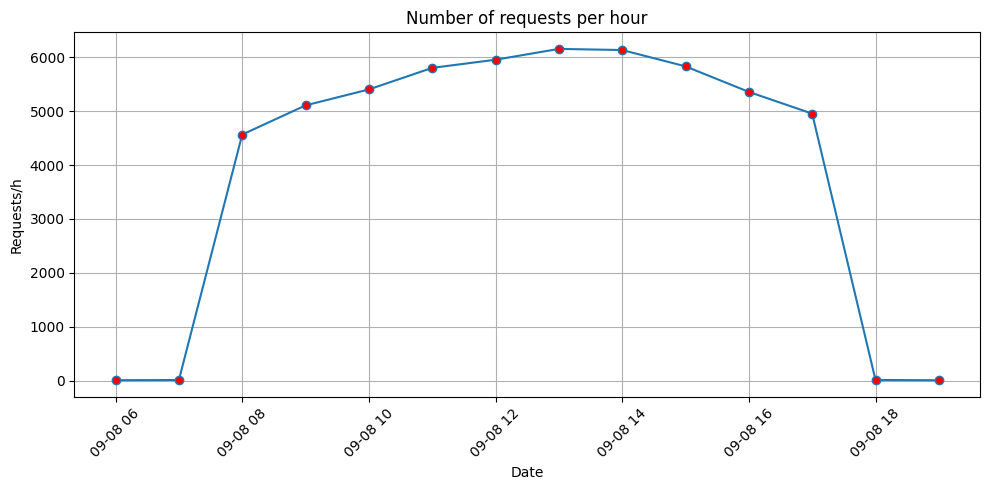

In [4]:
class SmoothModel(BaseModel):

    def __init__(self, *args, spread=0.025, **kwargs):
        super().__init__(*args, **kwargs)
        self.spread = spread

    def rate_function(self, date):
        base_rate = super().rate_function(date)
        if self.is_office_hours(date):
            # Adding spread/2 to balance (it will have less events in the beginning/end
            # but more events in the middle, thus getting closer to the given[
            # rate.
            factor = self.smoothing_factor(date.hour, self.spread) + self.spread/2
            base_rate *=  factor
        return base_rate


    def smoothing_factor(self, hour, spread):
        """
        The default spread value of 0.025 was found by manual experimentation.
        We wanted one that would give a factor of around 75% closer to the 
        limits of the office hours.

        >>> model = SmoothModel()
        >>> model.smoothing_factor(13, 0.025)
        np.float64(1.0)
        >>> 0.75 - model.smoothing_factor(model.office_hours_start, 0.025) < 0.05
        np.True_
        >>> 0.75 - model.smoothing_factor(model.office_hours_end, 0.025) < 0.05
        np.True_
        """
        hour = hour - self.office_hours_start
        work_day_length = self.office_hours_end - self.office_hours_start
        peak = work_day_length / 2
        return np.exp(-(hour-peak)**2/2*spread)

horizon = 14

start_time = D('2025-09-08 06:00')

smooth_model = SmoothModel()

event_simulation = simulate_requests(smooth_model, start_time, horizon, HOUR)
plot_simulation(event_simulation, marker='o')


### Requests tend to happen closer to each other

One last facet of our problem is that, unlike Poisson processes, requests _somewhat_ independent, but not _totally_. The occurrence of a request _usually_ indicates the chance of others arriving rose. We think of two main reasons for that:

1. a request can lead to download of other resources (e.g. CSS files and images);
2. a request from one person indicates other people may have to do it. (A concrete example is accessing the intranet from home to see if the company published a note about a recent event around the office, e.g. a flood).

One way to model it is as a [Hawkes process](https://hawkeslib.readthedocs.io/en/latest/tutorial.html). It fits perfectly to our first scenario, since Hawkes processes model events that cause others (i.e. self-exciting events), such as stock trade operations or earthquakes. That said, we believe it may be enough to also approximate the behavior of the second scenario. So let's extend our model a bit more.

In [5]:
class HawkesModel(SmoothModel):

    def __init__(self, *args, intensity=3, decay=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.intensity = intensity
        self.decay = decay
        self.event_count_list = []
        
    def rate_function(self, date):
        base_rate = super().rate_function(date)
        decay = self.decay_function()
        # When we have self-exciting events, it increases the number
        # of events on average by about the intensity. So, when
        # we had x events, then we will have x+intensity events.
        #
        # But the rate we got is what was in theory measured / estimated
        # from sampling: we want to maintain it. So here we scale down
        # the rating to try to keep it close to the original, but
        # still being affected by previous events.
        scaled_rate = base_rate
        return scaled_rate  + self.intensity*decay

    def register_event_count(self, date, count):
        super().register_event_count(date, count)
        self.event_count_list.append(count)

    def decay_function(self):
        """
        The libraries to simulate Hawkes processes are either discontinued or
        did not run in my machine for some reason, so let's implement it by hand :(
        """
        if not self.event_count_list:
            return 0
        event_count = self.event_count_list[-1]
        factor = self.decay * np.exp(-self.decay*event_count)
        return factor

This behavior will affect mostly the behavior during trough hours (i.e., the ones in which there are very little requests). To see how it will affect the results, let's plot it in a more glanular manner, using 10 minute intervals over 12 hours. We will only observe it during the low-rate times for clarity, since these are the more relevant periods:

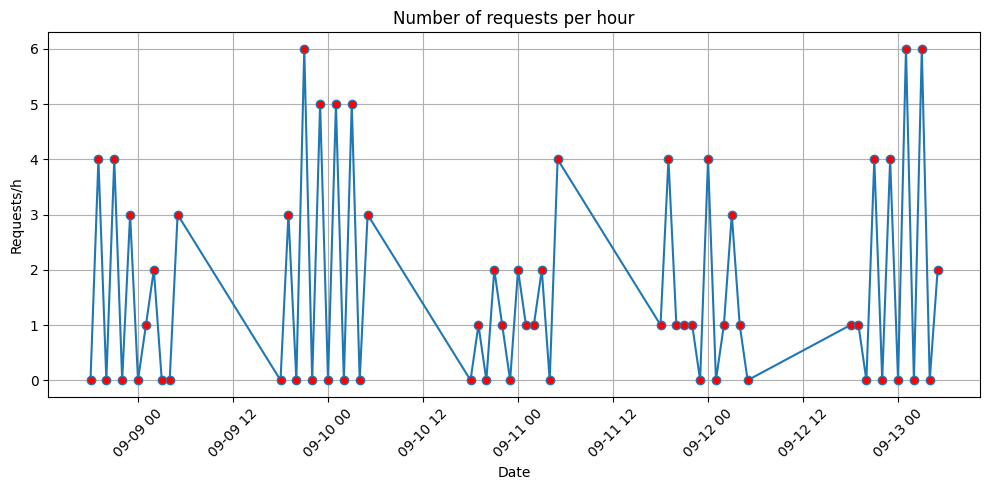

In [6]:
horizon = 12

start_time = D('2025-09-08 18:00')

model = HawkesModel()

event_simulation = simulate_requests(model, D('2025-09-08 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-09 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-10 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-11 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-12 18:00'), horizon, 1)

plot_simulation(event_simulation, marker='o')

Compare it with our smooth model. Note in the graph how the Hawkes model has more events closer to one another.

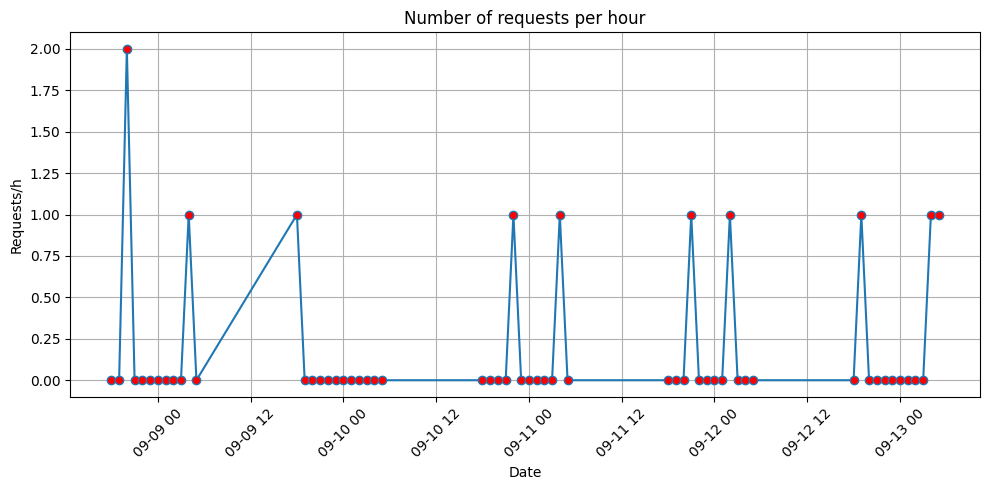

In [7]:
horizon = 12

start_time = D('2025-09-08 18:00')

model = SmoothModel()

event_simulation = simulate_requests(model, D('2025-09-08 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-09 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-10 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-11 18:00'), horizon, 1)
event_simulation |= simulate_requests(model, D('2025-09-12 18:00'), horizon, 1)

plot_simulation(event_simulation, marker='o')

### A final review of the model

So, how does this model fare? Let's check some stats from a simulation over 60 days:

In [8]:
horizon = 60*24

start_time = D('2025-09-08 00:00')

hawkes_model = HawkesModel()
hawkes_event_simulation = simulate_requests(hawkes_model, start_time, horizon, 10)

smooth_model = SmoothModel()
smooth_event_simulation = simulate_requests(smooth_model, start_time, horizon, 10)

base_model = BaseModel()
base_event_simulation = simulate_requests(base_model, start_time, horizon, 10)

def print_stats(title, simulation):
    values = list(simulation.values())
    print(f"Average ({title})", np.mean(values))
    print(f"Std ({title})", np.std(values))
    
print_stats('Base', base_event_simulation)
print_stats('Smooth', smooth_event_simulation)
print_stats('Hawkes', hawkes_event_simulation)

Average (Base) 459.7659722222222
Std (Base) 1143.9088341845445
Average (Smooth) 421.1736111111111
Std (Smooth) 1051.7890620130506
Average (Hawkes) 423.07916666666665
Std (Hawkes) 1048.0415859854327


Our goal was to match the original Poisson distribution’s average, but the mean dropped slightly, which may require further investigation.

Interestingly, the variance across time intervals decreases noticeably. Although this is initially surprising—since we introduced more randomness via self-exciting behavior—it makes sense. The base non-homogeneous Poisson model has large differences between intervals. By smoothing values during office hours and clustering events following an initial request, the number of events per interval moves closer to the mean.

Over longer intervals, the results appear even smoother:

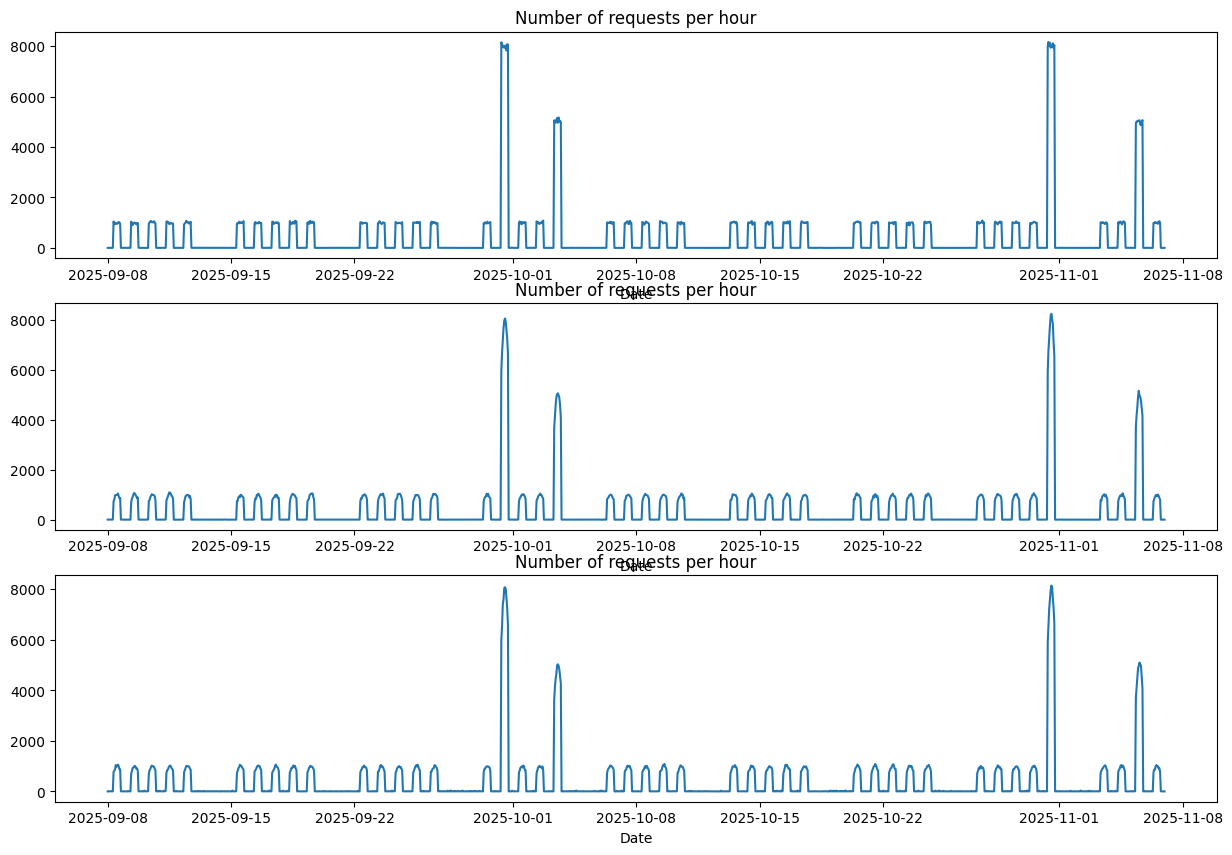

<Figure size 640x480 with 0 Axes>

In [11]:
def plot_to_axis(axis, title, events, marker=None, markerfacecolor='red', linestyle='-'):
    sorted_items = sorted(events.items())
    dates = [item[0] for item in sorted_items]
    values = [item[1] for item in sorted_items]
    axis.plot(dates, values, marker=marker, markerfacecolor='red', linestyle='-')
    axis.set_title('Number of requests per hour')
    axis.set_xlabel('Date')


figure, axis = plt.subplots(3, 1, figsize=(15, 10))
plot_to_axis(axis[0], 'Number of requests per hour (pure non-homogeneous Poisson)', base_event_simulation)
plot_to_axis(axis[1], 'Number of requests per hour (Smooth)', smooth_event_simulation)
plot_to_axis(axis[2], 'Number of requests per hour (Hawkes)', hawkes_event_simulation)
plt.show()
plt.tight_layout()


### Conclusion

The number of access requests to a web application is a quintenssential point process. The natural option is to model it as a Poisson process, which is not a bad start at all.

However, app access is a very seasonal process. Given that our goal is to investigate the behavior for informing auto-scalers, our model needs to be more precise when it comes to short time intervals. Thus a non-homogeneous Poisson process is more fit for when such granularity is needed.

Not only that, the rate function $\lambda(t)$ needs to be smooth enough to represent the transition between the trends in a way that is not very abrupt. In our preliminary work, we choose to smoothen the function by adding a deterministicu value returned by a bell function. It would be interesting to make $\lambda(t)$ a random variable as well, but we are not really confident it would make much difference, at least not without big data.

Finally, requests tends to happen closer to one another, either because a requests calls for another, or because different users tend to do the same thing in the same time window. We experimentes with using a Hawkes process over our smooth non-homogeneous Poisson function. The result was quite fascinanting: it seemed indeed similar to what we would expect from access request patterns, and even the variance was reduced.

A future work is to get real data to try such simulations with rates estimated from real samples. This though depends of bureaucratic process that can take some time.

### Appendix: External links
If you want to fiddle with the parameters of our distribution... today is your lucky day. The model is deployed in https://ysjrnfbnq7vzg6izsqhpv4.streamlit.app/ for experimentation.

If you want to see the source files, go to https://github.com/brandizzi/AEDI2025.

In [10]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=20)